In [ ]:
from tensorflow import argmax, expand_dims
from tensorflow.data import AUTOTUNE
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import matplotlib.pyplot as plt

import os
import seaborn as sns

import sys
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
FULL_PATH = f"/content/drive/My Drive/Diplom"
sys.path.append(FULL_PATH)

Mounted at /content/drive


# Loading and preparing dataset

Load training, validation, testing datasets

In [ ]:
img_size, batch_size, seed = (224, 224), 32, 42

train_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/Diplom/Dataset/train",
    labels='inferred',
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

val_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/Diplom/Dataset/val",
    labels='inferred',
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

test_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/Diplom/Dataset/Testing",
    labels='inferred',
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
print("Class labels:", class_names)

#Optimize with prefetching
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 4571 files belonging to 4 classes.
Found 1141 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Class labels: ['glioma', 'meningioma', 'notumor', 'pituitary']


Preview a batch of training images

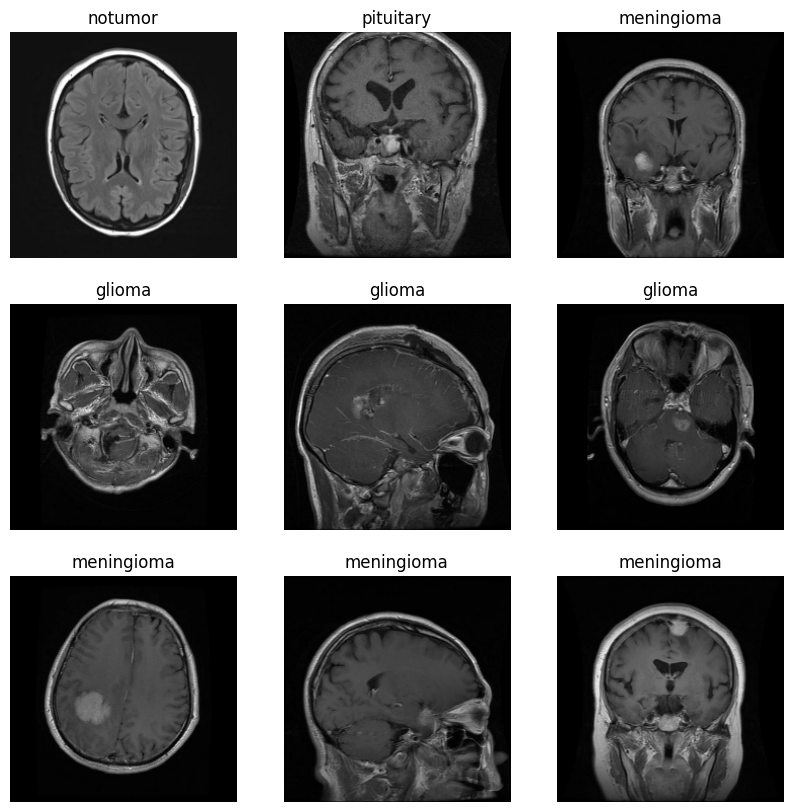

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = argmax(labels[i]).numpy()
        plt.title(class_names[label_index])
        plt.axis("off")

# Import & Prepare EfficientNetB0



Callbacks

In [ ]:
checkpoint_cb = callbacks.ModelCheckpoint(
    "efficientnetb0_brain_tumor.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

earlystop_cb = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

Build model, Freeze base model initially, Add custom top layers, Compile the model, Train the Model, Saving model

In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print(model.summary())

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[checkpoint_cb, earlystop_cb]
)

model.save("/content/drive/MyDrive/Diplom/efficientnetb0_trained.keras")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

None
Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4741 - loss: 1.1624

143/143 ━━━━━━━━━━━━━━━━━━━━ 988s 7s/step - accuracy: 0.4749 - loss: 1.1611 - val_accuracy: 0.7993 - val_loss: 0.5909
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7614 - loss: 0.6559

143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.7615 - loss: 0.6557 - val_accuracy: 0.8449 - val_loss: 0.4440
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8058 - loss: 0.5265

143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 123ms/step - accuracy: 0.8058 - loss: 0.5263 - val_accuracy: 0.8624 - val_loss: 0.3816
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8193 - loss: 0.4592

143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.8193 - loss: 0.4591 - val_accuracy: 0.8782 - val_loss: 0.3423
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8602 - loss: 0.4089

143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.8602 - loss: 0.4089 - val_accuracy: 0.8940 - val_loss: 0.3184
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8584 - loss: 0.3890

143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.8584 - loss: 0.3890 - val_accuracy: 0.8966 - val_loss: 0.3037
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8696 - loss: 0.3661

143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.8695 - loss: 0.3661 - val_accuracy: 0.8983 - val_loss: 0.2896
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8585 - loss: 0.3684

143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 0.8585 - loss: 0.3683 - val_accuracy: 0.9018 - val_loss: 0.2805
Epoch 9/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8718 - loss: 0.3454

143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.8718 - loss: 0.3453 - val_accuracy: 0.9071 - val_loss: 0.2715
Epoch 10/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8761 - loss: 0.3381

143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.8761 - loss: 0.3381 - val_accuracy: 0.9097 - val_loss: 0.2622
Epoch 11/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.8735 - loss: 0.3140 - val_accuracy: 0.9097 - val_loss: 0.2542
Epoch 12/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8793 - loss: 0.3202

143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.8793 - loss: 0.3201 - val_accuracy: 0.9141 - val_loss: 0.2492
Epoch 13/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8870 - loss: 0.3061

143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.8870 - loss: 0.3060 - val_accuracy: 0.9159 - val_loss: 0.2425
Epoch 14/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.8949 - loss: 0.2873 - val_accuracy: 0.9159 - val_loss: 0.2380
Epoch 15/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.8942 - loss: 0.2697 - val_accuracy: 0.9106 - val_loss: 0.2343
Epoch 16/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.9000 - loss: 0.2759 - val_accuracy: 0.9141 - val_loss: 0.2303
Epoch 17/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8886 - loss: 0.2847

143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.8887 - loss: 0.2846 - val_accuracy: 0.9167 - val_loss: 0.2263
Epoch 18/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9051 - loss: 0.2703

143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.9051 - loss: 0.2704 - val_accuracy: 0.9194 - val_loss: 0.2192
Epoch 19/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8999 - loss: 0.2628

143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 149ms/step - accuracy: 0.8999 - loss: 0.2628 - val_accuracy: 0.9220 - val_loss: 0.2184
Epoch 20/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9064 - loss: 0.2579 - val_accuracy: 0.9211 - val_loss: 0.2150
Epoch 21/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - accuracy: 0.9096 - loss: 0.2539 - val_accuracy: 0.9220 - val_loss: 0.2093
Epoch 22/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9041 - loss: 0.2457

143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.9041 - loss: 0.2457 - val_accuracy: 0.9238 - val_loss: 0.2073
Epoch 23/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9116 - loss: 0.2368

143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.9116 - loss: 0.2368 - val_accuracy: 0.9281 - val_loss: 0.2055
Epoch 24/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9173 - loss: 0.2277 

143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.9172 - loss: 0.2277 - val_accuracy: 0.9299 - val_loss: 0.2018
Epoch 25/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9175 - loss: 0.2389 - val_accuracy: 0.9264 - val_loss: 0.1992


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,541 (16.70 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 164,486 (642.53 KB)

Plot Training Curves

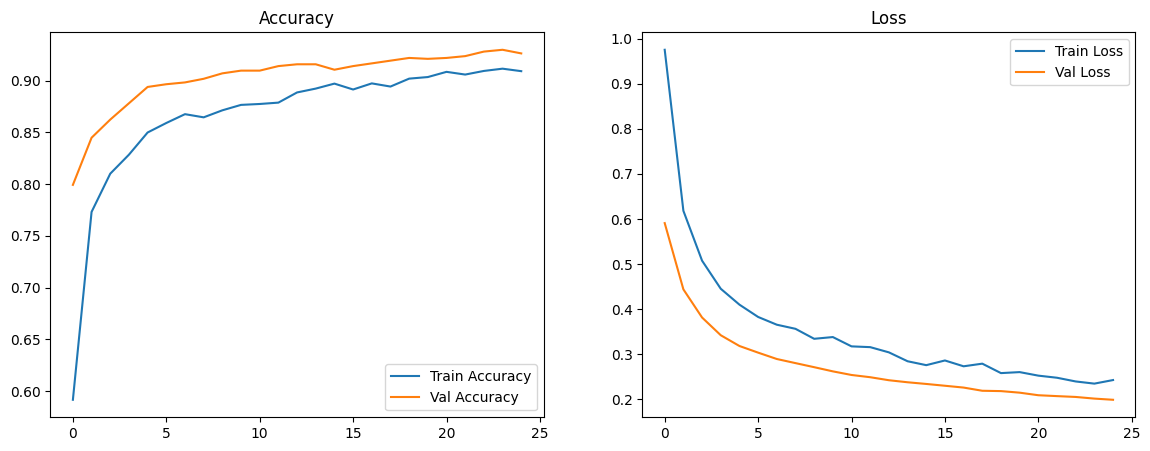

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


# Evaluate EfficientNetB0

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 284s 7s/step - accuracy: 0.8758 - loss: 0.2960
Test Accuracy: 0.9085
Test Loss: 0.2266


41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 250ms/step
              precision    recall  f1-score   support

      glioma       0.92      0.83      0.87       300
  meningioma       0.81      0.84      0.83       306
     notumor       0.95      0.98      0.96       405
   pituitary       0.94      0.97      0.96       300

    accuracy                           0.91      1311
   macro avg       0.91      0.90      0.90      1311
weighted avg       0.91      0.91      0.91      1311



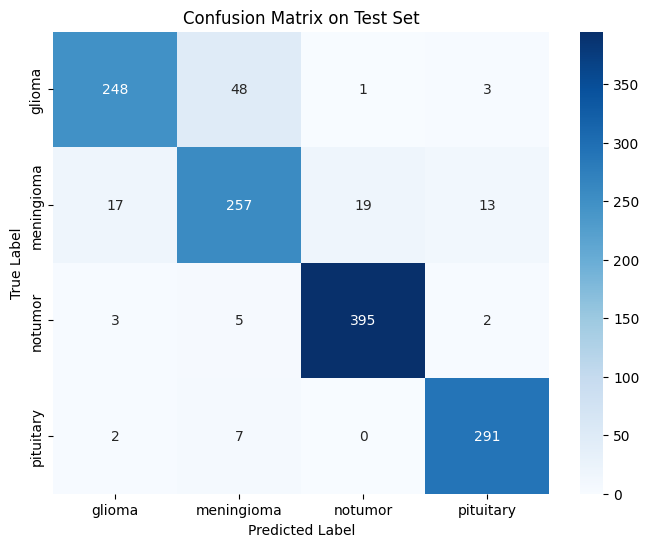

In [ ]:
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
true_classes = np.argmax(true_labels, axis=1)
pred_probs = model.predict(test_ds)
pred_classes = np.argmax(pred_probs, axis=1)

print(classification_report(true_classes, pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


## Evaluate/Test on Individual Images

In [ ]:
class_names = class_names

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    pred_class = class_names[np.argmax(predictions)]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class}")
    plt.show()

    return pred_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


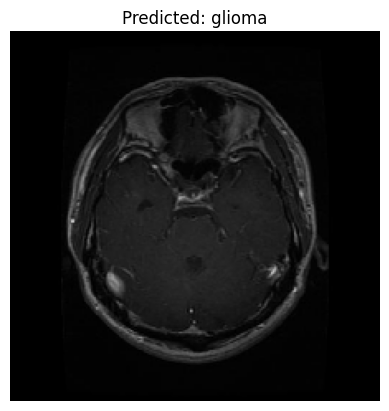

'glioma'

In [ ]:
predict_image("/content/drive/MyDrive/Diplom/Dataset/Testing/glioma/Te-gl_0012.jpg", model)

 # Prepare EfficientNetB0 Fine_Tune

In [ ]:

# 1. Early stopping (to prevent overfitting)
earlystop_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# 2. Model checkpoint (save best weights)
checkpoint_cb = callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/brain_tumor_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# 3. Reduce learning rate if validation stops improving
reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    min_lr=1e-7
)

In [ ]:
base_model.trainable = True

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 4,004,832 (15.28 MB)

 Non-trainable params: 209,223 (817.28 KB)

In [ ]:
  model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,218,889 (31.35 MB)

 Trainable params: 4,004,832 (15.28 MB)

 Non-trainable params: 209,223 (817.28 KB)

 Optimizer params: 4,004,834 (15.28 MB)

In [ ]:
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7129 - loss: 0.7855
Epoch 1: val_loss improved from inf to 0.30618, saving model to /content/drive/MyDrive/brain_tumor_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 124s 492ms/step - accuracy: 0.7132 - loss: 0.7846 - val_accuracy: 0.8826 - val_loss: 0.3062 - learning_rate: 1.0000e-05
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8436 - loss: 0.4491
Epoch 2: val_loss improved from 0.30618 to 0.28022, saving model to /content/drive/MyDrive/brain_tumor_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 0.8437 - loss: 0.4489 - val_accuracy: 0.8992 - val_loss: 0.2802 - learning_rate: 1.0000e-05
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8767 - loss: 0.3484
Epoch 3: val_loss improved from 0.28022 to 0.24850, saving model to /content/drive/MyDrive/brain_tumor_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 147ms/step - accuracy: 0.8767 - loss: 0.3483 - val_accuracy: 0.9132 - val_loss: 0.2485 - learning_rate: 1.0000e-05
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8986 - loss: 0.3000
Epoch 4: val_loss improved from 0.24850 to 0.22198, saving model to /content/drive/MyDrive/brain_tumor_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.8986 - loss: 0.2999 - val_accuracy: 0.9211 - val_loss: 0.2220 - learning_rate: 1.0000e-05
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9151 - loss: 0.2442
Epoch 5: val_loss improved from 0.22198 to 0.20010, saving model to /content/drive/MyDrive/brain_tumor_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 171ms/step - accuracy: 0.9151 - loss: 0.2442 - val_accuracy: 0.9264 - val_loss: 0.2001 - learning_rate: 1.0000e-05
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9227 - loss: 0.2200
Epoch 6: val_loss improved from 0.20010 to 0.18099, saving model to /content/drive/MyDrive/brain_tumor_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 170ms/step - accuracy: 0.9227 - loss: 0.2200 - val_accuracy: 0.9325 - val_loss: 0.1810 - learning_rate: 1.0000e-05
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9284 - loss: 0.2061
Epoch 7: val_loss improved from 0.18099 to 0.16587, saving model to /content/drive/MyDrive/brain_tumor_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - accuracy: 0.9284 - loss: 0.2061 - val_accuracy: 0.9351 - val_loss: 0.1659 - learning_rate: 1.0000e-05
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9404 - loss: 0.1708
Epoch 8: val_loss improved from 0.16587 to 0.14877, saving model to /content/drive/MyDrive/brain_tumor_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - accuracy: 0.9404 - loss: 0.1708 - val_accuracy: 0.9439 - val_loss: 0.1488 - learning_rate: 1.0000e-05
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9505 - loss: 0.1511
Epoch 9: val_loss improved from 0.14877 to 0.13551, saving model to /content/drive/MyDrive/brain_tumor_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 157ms/step - accuracy: 0.9505 - loss: 0.1511 - val_accuracy: 0.9439 - val_loss: 0.1355 - learning_rate: 1.0000e-05
Epoch 10/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9543 - loss: 0.1364
Epoch 10: val_loss improved from 0.13551 to 0.12507, saving model to /content/drive/MyDrive/brain_tumor_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 169ms/step - accuracy: 0.9543 - loss: 0.1365 - val_accuracy: 0.9500 - val_loss: 0.1251 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 10.


In [ ]:
model.save("/content/drive/MyDrive/Diplom/efficientnetb0_Fine-Tune.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 129 variables whereas the saved optimizer has 256 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


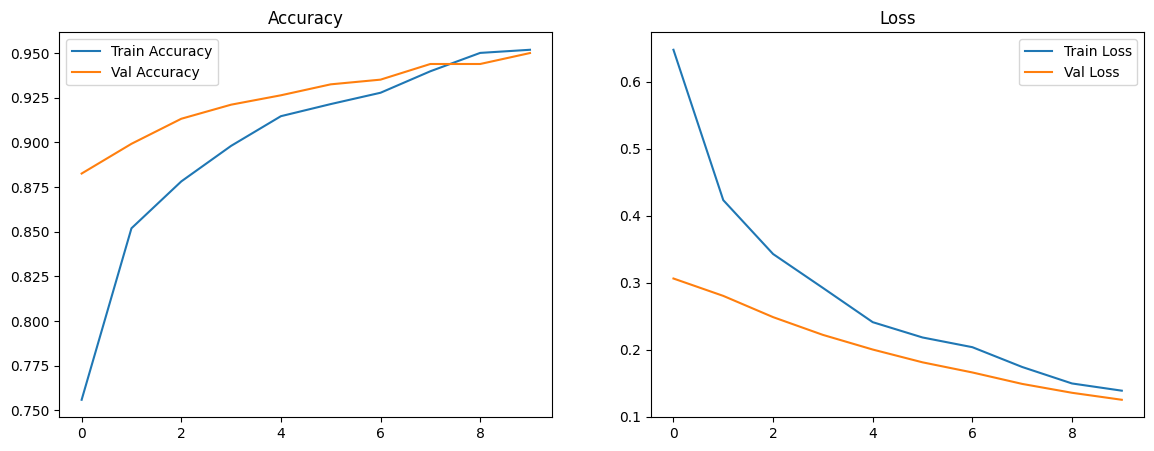

In [ ]:
acc = fine_tune_history.history['accuracy']
val_acc = fine_tune_history.history['val_accuracy']
loss = fine_tune_history.history['loss']
val_loss = fine_tune_history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


# Evaluate

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.9185 - loss: 0.1931
Test Accuracy: 0.9458
Test Loss: 0.1383


41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step
              precision    recall  f1-score   support

      glioma       0.97      0.90      0.93       300
  meningioma       0.89      0.89      0.89       306
     notumor       0.95      0.99      0.97       405
   pituitary       0.96      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



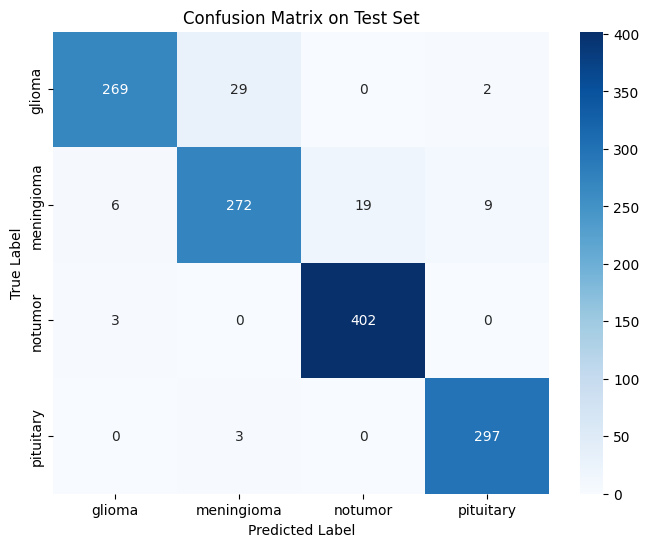

In [ ]:
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
true_classes = np.argmax(true_labels, axis=1)

pred_probs = model.predict(test_ds)
pred_classes = np.argmax(pred_probs, axis=1)

print(classification_report(true_classes, pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


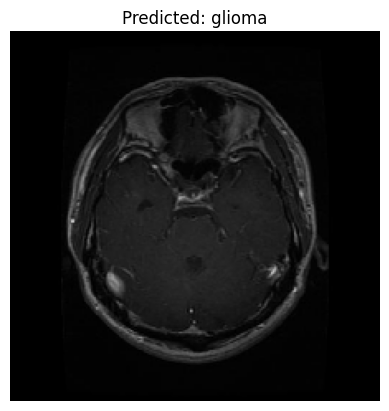

'glioma'

In [ ]:
predict_image("/content/drive/MyDrive/Diplom/Dataset/Testing/glioma/Te-gl_0012.jpg", model)